In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset

In [37]:
# Read a file using pandas
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
path = '/content/drive/My Drive/Nat_Cat_Exercise/Events.csv'
df = pd.read_csv(path)

In [39]:
df = df.dropna(subset=['title'])

In [40]:
# Drop exact duplicate clean titles
df = df.drop_duplicates(subset='title', keep='first').reset_index(drop=True)
print("New shape after deduplication:", df.shape)

New shape after deduplication: (65158, 8)


In [41]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 116.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [42]:
!pip install geonamescache

In [45]:
import spacy
from nltk.tokenize import word_tokenize
nlp = spacy.load("en_core_web_sm")
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Explicitly download punkt_tab
from nltk.corpus import stopwords

# Load NLP tools
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [46]:
def clean_title(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    doc = nlp(" ".join(filtered_tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]
    return " ".join(lemmatized_tokens)

df['clean_title'] = df['title'].astype(str).apply(clean_title)


In [47]:
import spacy
import geonamescache

# Load spaCy model
#nlp = spacy.load("en_core_web_sm")

# Load GeoNames country and city names
gc = geonamescache.GeonamesCache()
countries = set([c['name'] for c in gc.get_countries().values()])
cities = set([c['name'] for c in gc.get_cities().values()])
gazetteer = countries.union(cities)

# Function to check if a title has a real location
def has_location(text):
    doc = nlp(text)

    # Rule 1: spaCy NER match with gazetteer
    for ent in doc.ents:
        if ent.label_ in ["GPE", "LOC", "FAC"]:
            if ent.text.strip().title() in gazetteer:
                return True

    # Rule 2: Token-level backup match
    tokens = [t.text.strip().title() for t in doc if t.is_alpha]
    if any(tok in gazetteer for tok in tokens):
        return True

    return False


In [48]:
# 6. Detect Nat-Cat Keyword
CATEGORY_KEYWORDS = {
    'Earthquakes': [
        'earthquake', 'tremor', 'seismic', 'quake', 'aftershock', 'foreshock',
        'seism', 'epicenter', 'hypocenter', 'magnitude', 'richter scale',
        'seismic waves', 'ground shaking', 'fault line', 'tectonic', 'liquefaction',
        'seismograph', 'seismology', 'earth movement', 'earth vibration'
    ],

    'Hurricanes': [
        'hurricane', 'typhoon', 'cyclone', 'tropical storm', 'storm surge',
        'eye wall', 'rain bands', 'wind speed', 'category storm', 'tropical depression',
        'gale', 'tempest', 'monsoon', 'low pressure', 'storm system', 'hurricane warning',
        'hurricane watch', 'storm track', 'landfall', 'saffir-simpson'
    ],

    'Tornadoes': [
        'tornado', 'twister', 'funnel cloud', 'whirlwind', 'supercell',
        'mesocyclone', 'vortex', 'windstorm', 'tornado warning', 'tornado watch',
        'tornado siren', 'debris cloud', 'tornado alley', 'rotation', 'wall cloud',
        'hook echo', 'doppler radar', 'fujita scale', 'enhanced fujita', 'tornado outbreak'
    ],

    'Floods': [
        'flood', 'flooding', 'inundation', 'deluge', 'flash flood',
        'torrent', 'high water', 'overflow', 'submersion', 'waterlogging',
        'floodwaters', 'flood damage', 'flood alert', 'flood warning', 'flood watch',
        'levee breach', 'dam break', 'runoff', 'water rise', 'coastal flooding'
    ],

    'Wildfires': [
        'wildfire', 'bushfire', 'forest fire', 'brush fire', 'grass fire',
        'wildland fire', 'firestorm', 'conflagration', 'ember', 'fire spread',
        'fire line', 'fire suppression', 'fire evacuation', 'smoke plume', 'fire season',
        'fire danger', 'red flag warning', 'backfire', 'firebreak', 'containment line'
    ],

    'Tsunamis': [
        'tsunami', 'tidal wave', 'seismic wave', 'harbor wave', 'ocean surge',
        'coastal flooding', 'wave height', 'run-up', 'tsunami warning', 'tsunami alert',
        'tidal bore', 'tsunami advisory', 'seiche', 'displacement wave', 'tsunami siren',
        'tsunami evacuation', 'tsunami zone', 'tsunami buoys', 'megatsunami', 'tsunami ready'
    ],

    'Volcanic eruptions': [
        'volcano', 'eruption', 'lava', 'magma', 'ash cloud',
        'pyroclastic', 'volcanic ash', 'crater', 'caldera', 'fumarole',
        'geyser', 'volcanic gas', 'tephra', 'lahar', 'volcanic bomb',
        'pumice', 'volcanic winter', 'vog', 'volcano alert', 'volcanic explosivity index'
    ]
}
def is_natcat_event(title):
    title = title.lower()
    has_event = any(kw in title for kws in CATEGORY_KEYWORDS.values() for kw in kws)
    return has_event and has_location(title)

df['is_natcat'] = df['clean_title'].apply(is_natcat_event)

In [49]:
# 7. Filter
df_natcat = df[df['is_natcat'] == True].copy()
print("Filtered shape:", df_natcat.shape)

Filtered shape: (18222, 10)


In [50]:
!pip install keybert

In [51]:
from keybert import KeyBERT
from collections import defaultdict

In [52]:
CATEGORY_KEYWORDS = {
    'Earthquakes': ['earthquake', 'tremor', 'seismic', 'quake','tsunami', 'tidal wave', 'seismic wave'],
    'Floods': ['flood', 'flooding', 'inundation'],
    'Volcanic eruptions': ['volcano', 'eruption', 'lava'],
    'Tornadoes': ['tornado', 'twister', 'cyclone','hurricane', 'typhoon', 'cyclone'],
    'Wildfires': ['wildfire', 'bushfire', 'forest fire'],

}

In [53]:
kw_model = KeyBERT()

In [54]:
def classify_disaster(title, threshold=0.3):
    # Extract keywords
    keywords = kw_model.extract_keywords(
        title,
        keyphrase_ngram_range=(1, 2),
        stop_words='english',
        top_n=5
    )

    # Filter keywords by score
    filtered_keywords = [kw for kw, score in keywords if score >= threshold]

    # Calculate category scores
    category_scores = defaultdict(int)
    for category, terms in CATEGORY_KEYWORDS.items():
        for term in terms:
            if any(term in kw.lower() for kw in filtered_keywords):
                category_scores[category] += 1

    # Determine predicted category
    predicted_category = max(category_scores.items(), key=lambda x: x[1])[0] if category_scores else "Unknown"

    return predicted_category, filtered_keywords

In [55]:
# Apply classification to each title
df_natcat['predicted_category'] = df_natcat['title'].apply(classify_disaster)

In [56]:
df_natcat.reset_index(drop=True, inplace=True)

In [57]:
df_natcat['key_Bert'] = df_natcat['predicted_category'].apply(lambda x: x[0])

In [58]:
df_natcat.key_Bert.value_counts()

,count
key_Bert,
Earthquakes,5516
Floods,3870
Tornadoes,3773
Wildfires,2728
Volcanic eruptions,1312
Unknown,1023


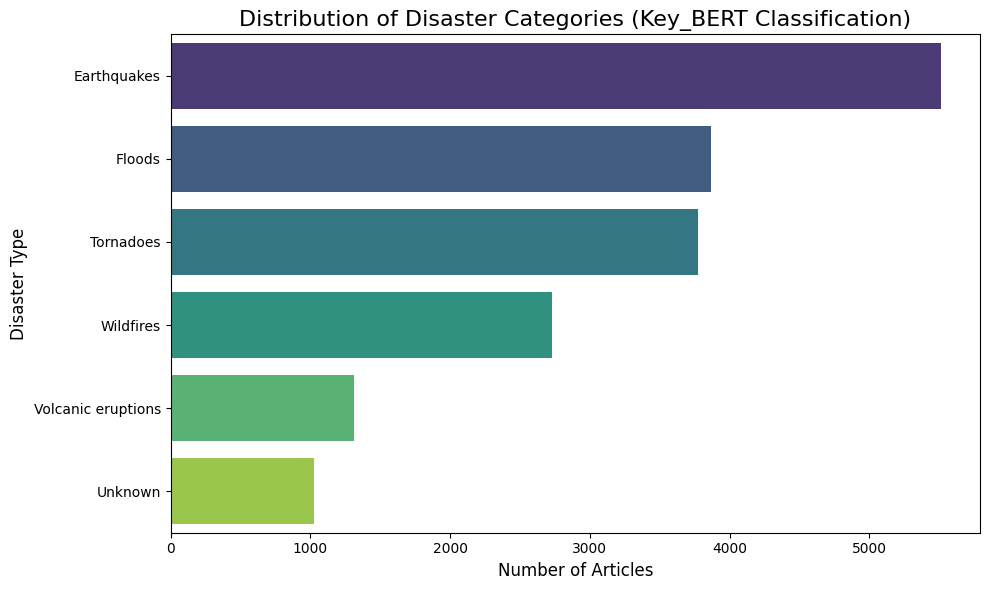

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df_natcat, y='key_Bert', order=df_natcat['key_Bert'].value_counts().index, palette='viridis')

plt.title('Distribution of Disaster Categories (Key_BERT Classification)', fontsize=16)
plt.xlabel('Number of Articles', fontsize=12)
plt.ylabel('Disaster Type', fontsize=12)

plt.tight_layout()
plt.show()

In [60]:
def test_classify_disaster():
    """Simple test cases for classify_disaster function"""

    # Example 1: Clear natural disaster
    title = "Major earthquake hits California"
    category, keywords = classify_disaster(title)
    print(f"Test 1 - '{title}':")
    print(f"  Category: {category}")
    print(f"  Keywords: {keywords}")
    print()

    # Example 2: Industrial accident
    title = "Chemical plant explosion in Texas"
    category, keywords = classify_disaster(title)
    print(f"Test 2 - '{title}':")
    print(f"  Category: {category}")
    print(f"  Keywords: {keywords}")
    print()

    # Example 3: Below threshold (should return Unknown)
    title = "Minor incident at local factory"
    category, keywords = classify_disaster(title, threshold=0.5)
    print(f"Test 3 - '{title}':")
    print(f"  Category: {category}")
    print(f"  Keywords: {keywords}")
    print()

    # Example 4: No matching category
    title = "Celebrity wedding announcement"
    category, keywords = classify_disaster(title)
    print(f"Test 4 - '{title}':")
    print(f"  Category: {category}")
    print(f"  Keywords: {keywords}")

# Run the tests
if __name__ == "__main__":
    test_classify_disaster()

Test 1 - 'Major earthquake hits California':
  Category: Earthquakes
  Keywords: ['earthquake hits', 'major earthquake', 'hits california', 'earthquake', 'california']

Test 2 - 'Chemical plant explosion in Texas':
  Category: Unknown
  Keywords: ['explosion texas', 'plant explosion', 'explosion', 'chemical plant', 'chemical']

Test 3 - 'Minor incident at local factory':
  Category: Unknown
  Keywords: ['incident local', 'minor incident', 'incident', 'local factory', 'factory']

Test 4 - 'Celebrity wedding announcement':
  Category: Unknown
  Keywords: ['celebrity wedding', 'wedding announcement', 'wedding', 'celebrity', 'announcement']


In [61]:
!pip install bertopic
from bertopic import BERTopic

In [62]:
from bertopic import BERTopic
import pandas as pd

# Fit BERTopic
topic_model = BERTopic(language="english", nr_topics=5)
topics, probs = topic_model.fit_transform(df_natcat['clean_title'])

# STEP 1: Display topic keywords for manual inspection
print("Topic Keywords:")
for topic_num in set(topics):
    print(f"Topic {topic_num}: {topic_model.get_topic(topic_num)}")

# STEP 2: Manually map topics to your 5 disaster categories
# After inspecting above output, update this dictionary accordingly
manual_topic_map = {
    0: "Earthquake",
    1: "Tornado",
    2: "Volcano",
    3: "Floods",
    4: "Wildfire"
}

# STEP 3: Create DataFrame with results
df_result = pd.DataFrame({
    "title": df_natcat['clean_title'],
    "topic_num": topics,
    "topic_label": [manual_topic_map.get(t, "Unknown") for t in topics]
})

print("\nFinal Categorized Titles:")
#print(df)


Topic Keywords:
Topic 0: [('earthquake', np.float64(0.16671893635787488)), ('magnitude', np.float64(0.08369459263975734)), ('near', np.float64(0.07810680010364025)), ('mag', np.float64(0.07681315021255873)), ('light', np.float64(0.07410195037585651)), ('quake', np.float64(0.07120158809843172)), ('strike', np.float64(0.06635464141595467)), ('volcano', np.float64(0.06582543501800663)), ('japan', np.float64(0.05995042015953319)), ('hit', np.float64(0.0446149457168249))]
Topic 1: [('flood', np.float64(0.10901718196009551)), ('tornado', np.float64(0.0871338010953988)), ('hurricane', np.float64(0.05986590655294015)), ('storm', np.float64(0.0458794312787377)), ('flooding', np.float64(0.037393342926378664)), ('florida', np.float64(0.034956516607843505)), ('warning', np.float64(0.034937091452989726)), ('helene', np.float64(0.03314956840887267)), ('rain', np.float64(0.031355873779241136)), ('county', np.float64(0.030436475273088466))]
Topic 2: [('wildfire', np.float64(0.24602759028748872)), ('fi

In [63]:
df_result.head()

,title,topic_num,topic_label
0,iceland volcano bring tourist island country,0,Earthquake
1,tornado scorcher ice storm top 10 weather even...,1,Tornado
2,yellowstone supervolcano magma chamber huge er...,-1,Unknown
3,japan earthquake coastal resident tell evacuat...,0,Earthquake
4,topic tsunami sydney morning herald,-1,Unknown


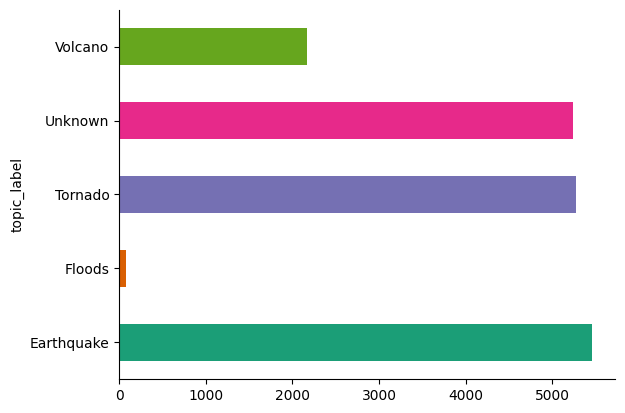

In [64]:
# @title topic_label

from matplotlib import pyplot as plt
import seaborn as sns
df_result.groupby('topic_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [65]:
df_result.topic_label.value_counts()

,count
topic_label,
Earthquake,5455
Tornado,5278
Unknown,5240
Volcano,2165
Floods,84


In [66]:
from bertopic import BERTopic
from itertools import combinations
from sklearn.metrics import jaccard_score
import numpy as np

def get_topic_keywords(topic_model, top_n=10):
    """Extract top N keywords from each topic."""
    topic_words = []
    for topic_num in topic_model.get_topics().keys():
        words = [word for word, _ in topic_model.get_topic(topic_num)[:top_n]]
        topic_words.append(set(words))
    return topic_words

def compute_jaccard_distinctiveness(topics_keywords):
    """Calculate average Jaccard distinctiveness across all topic pairs."""
    jaccard_scores = []
    for a, b in combinations(topics_keywords, 2):
        intersection = len(a.intersection(b))
        union = len(a.union(b))
        jaccard = intersection / union if union != 0 else 0
        jaccard_scores.append(1 - jaccard)  # Distinctiveness = 1 - similarity
    return np.mean(jaccard_scores)

# ▶️ Run the evaluation
topic_keywords = get_topic_keywords(topic_model, top_n=10)
coherence_score = compute_jaccard_distinctiveness(topic_keywords)

print(f"🧠 Custom Coherence Score (Jaccard Distinctiveness): {coherence_score:.4f}")


🧠 Custom Coherence Score (Jaccard Distinctiveness): 0.9462


In [67]:
coherence_score

np.float64(0.9462418300653596)